In [5]:
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np
import pandas as pd
import yfinance as yf
import plotly.graph_objs as go

In [4]:

pip install pmdarima

You should consider upgrading via the 'C:\Users\soumm\anaconda3\python.exe -m pip install --upgrade pip' command.


  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5


In [6]:
data = yf.download(tickers='DOGE-USD')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550
2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520
2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080
2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960
2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270
...,...,...,...,...,...,...
2022-02-14,0.148869,0.150132,0.143649,0.146003,0.146003,898042727
2022-02-15,0.145996,0.152199,0.145203,0.151761,0.151761,674961496
2022-02-16,0.151779,0.151824,0.146771,0.149095,0.149095,505588732


In [7]:
fig = go.Figure()

fig.add_trace(go.Candlestick(x=data.index,
                             open=data['Open'],
                             high=data['High'],
                             low=data['Low'],
                             close=data['Close'], name='market data'))
fig.update_layout(
    title='BTC-USD live share price evolution',
    yaxis_title='Stock price (USD per BTC)'
)
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
                      dict(count=1, label='1h', step='hour', stepmode='backward'),
                      dict(count=12, label='12h', step='hour', stepmode='backward'),
                      dict(count=24, label='HTD', step='hour', stepmode='todate'),
                      dict(count=3, label='3d', step='day', stepmode='backward'),
                      dict(step='all')
        ])
    )
)
fig.show()

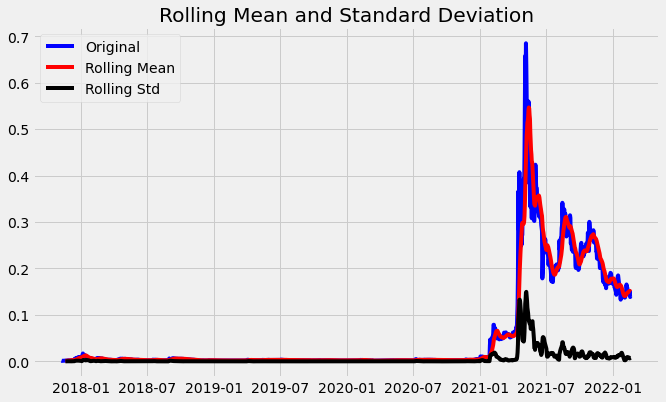

Results of dickey fuller test
Test Statistics                  -1.998268
p-value                           0.287333
No. of lags used                 24.000000
Number of observations used    1538.000000
critical value (1%)              -3.434609
critical value (5%)              -2.863421
critical value (10%)             -2.567771
dtype: float64


In [21]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

- the p-value is greater than 0.05 => we cannot reject the Null hypothesis.
- the test statistics is greater than the critical values => the data is non-stationary.

<Figure size 720x432 with 0 Axes>

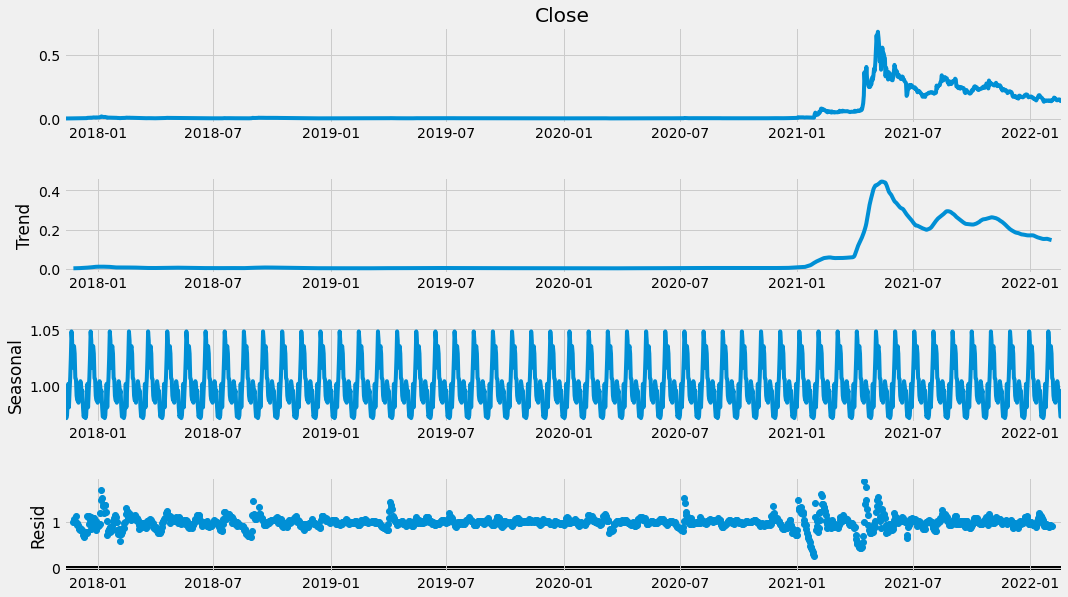

In [22]:
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


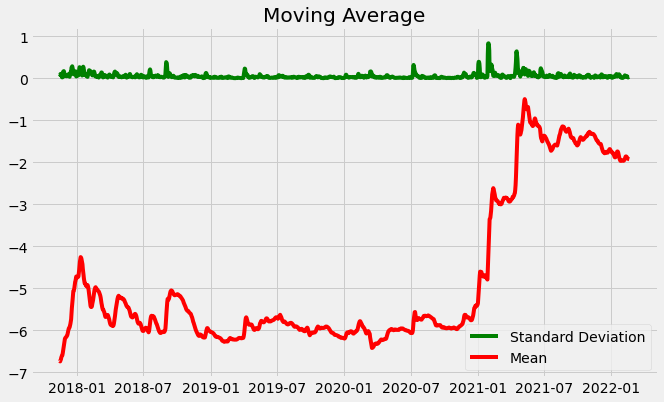

In [23]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(6).mean()
std_dev = df_log.rolling(6).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="green", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

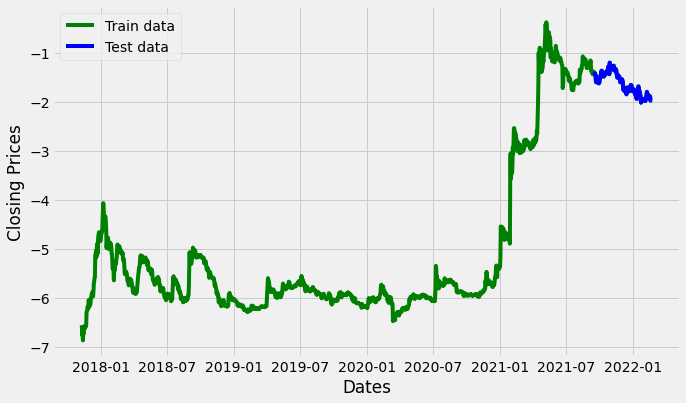

In [24]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [15]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2934.694, Time=0.51 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2934.138, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2934.304, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2933.758, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2942.186, Time=2.51 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2943.015, Time=4.98 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2935.339, Time=0.55 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-2953.023, Time=4.13 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-2954.866, Time=0.85 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-2954.486, Time=0.36 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0] intercept
Total fit time: 15.355 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1403
Model:               SARIMAX(3, 1, 0)   Log Likelih

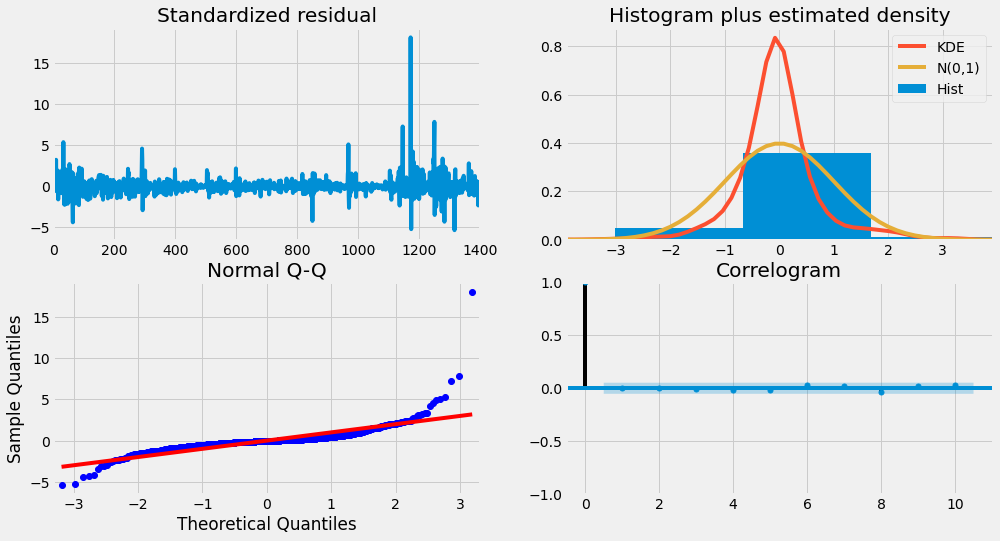

In [16]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

- Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.
- Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

conclusion: it seems to be a good fit. Let’s start forecasting the stock prices.

In [17]:
model = ARIMA(train_data, order=(3, 1, 0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1402
Model:                 ARIMA(3, 1, 0)   Log Likelihood                1482.433
Method:                       css-mle   S.D. of innovations              0.084
Date:                Sat, 19 Feb 2022   AIC                          -2954.867
Time:                        02:18:46   BIC                          -2928.638
Sample:                    11-13-2017   HQIC                         -2945.063
                         - 09-14-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0039      0.003      1.548      0.122      -0.001       0.009
ar.L1.D.Close     0.0398      0.027      1.501      0.133      -0.012       0.092
ar.L2.D.Close    -0.0521      0.027     

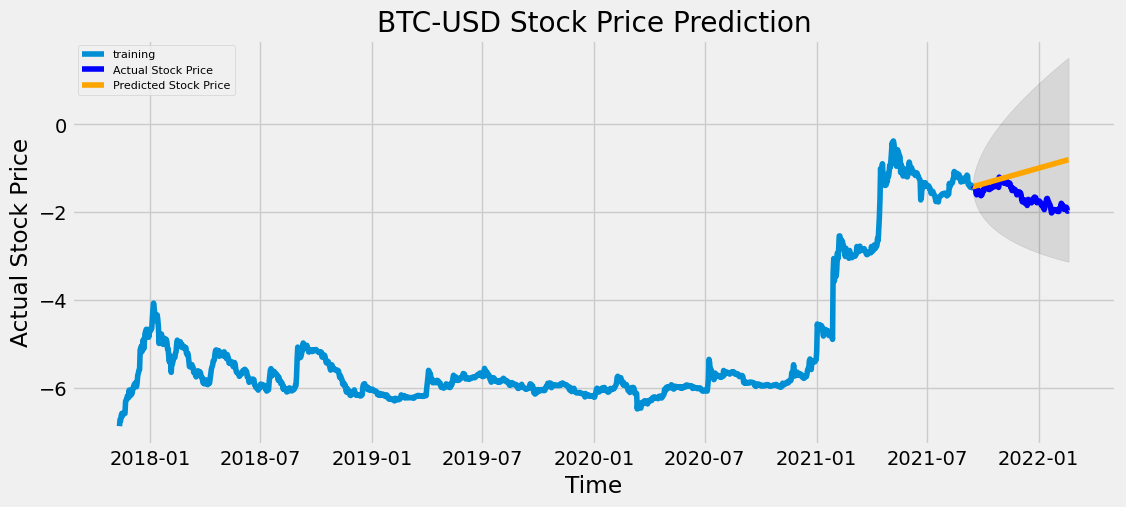

In [25]:
# Forecast with 95% confidence
fc, se, conf = fitted.forecast(157, alpha=0.05) 
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('BTC-USD Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [26]:
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.41213191657760484
MAE: 0.5181587743898197
RMSE: 0.6419750124246307
MAPE: 0.29292633504360405
